# Projet d'analyse des résultats des détections des exoplanètes par le télescope Kepler

Source : This file was produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu
Tue Jan 23 10:50:14 2024

### Objectif :
A partir de la validité des résultats de détection des exoplanètes par le télescope Kepler obtenir un modèle de prédiction de la probabilité d'avoir un exoplanète sur une planète Terrestre.

### Application PCA sur dataset puis modèle CNN



In [1]:
import os
from datetime import datetime

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

import seaborn as sns

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model, save_model


In [2]:

# Charger ensemble de données ici (new_data par exemple)
new_data = pd.read_csv('./dataset/data_resampled.csv')
new_data.head()

,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,...,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err,target
0,4499.0,89.0,-89.0,4.635,0.032,-0.020,-0.26,0.15,-0.15,0.639,...,0.210,0.210,0.190,-0.41,0.180,-0.43,0.220,0.59,0.190,1
1,5365.0,191.0,-175.0,3.669,0.816,-0.204,-0.04,0.30,-0.30,2.872,...,0.076,14.558,0.099,-13.90,0.072,4.37,0.081,14.57,0.077,0
2,6014.0,190.0,-211.0,4.436,0.072,-0.217,-0.04,0.25,-0.30,1.021,...,0.620,0.500,0.980,0.14,0.930,-0.40,0.620,0.42,0.860,1
3,4498.0,90.0,-90.0,4.661,0.012,-0.042,-0.08,0.15,-0.15,0.635,...,0.270,0.130,0.600,0.58,0.710,-0.25,0.270,0.63,0.590,1
4,5839.0,105.0,-105.0,4.327,0.156,-0.104,-0.28,0.15,-0.15,1.067,...,0.630,0.570,0.580,0.40,0.610,0.12,0.730,0.41,0.570,1


ACP


In [4]:
# Séparation des caractéristiques (X) et de la cible (y)
X = new_data.drop('target', axis=1)
y = new_data['target']

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer l'ACP
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_scaled)

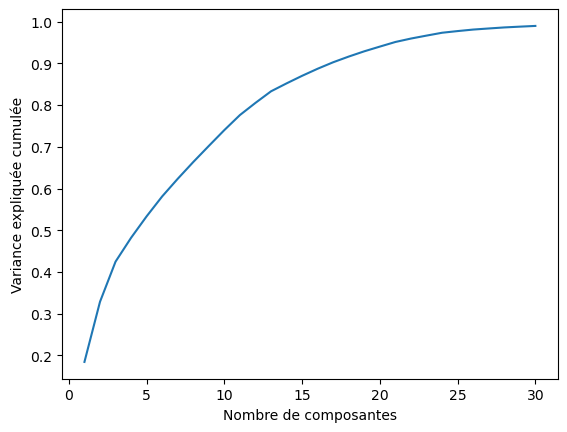

In [10]:
# Détermination du nombre de composantes
import matplotlib.pyplot as plt

plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.show()

In [11]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [12]:

# Normalisation des caractéristiques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Reshape des données pour convenir à l'entrée d'un CNN
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


Les modèles

In [13]:
def get_model1() :
    # Création du modèle CNN
    model = keras.Sequential([
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Utiliser 'softmax' si vplus de deux classes
    ])

    return model

def get_model2() :
    model = keras.Sequential([
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

chargement du modèle

In [14]:
model = get_model2()
modele_nom = 'model2_pca'
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 64)            256       
                                                                 
 batch_normalization (BatchN  (None, 28, 64)           256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 128)           24704     
                                                                 
 batch_normalization_1 (Batc  (None, 12, 128)          512       
 hNormalization)                                                 
                                                        

Les callbacks

In [15]:
# ---- Callback tensorboard


log_dir = "./logs/tb_" + modele_nom + "_" + datetime.now().strftime("%Y%m%d_%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = "./models/best-"+modele_nom+".h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='val_accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = "./models/"+modele_nom+"-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

path=os.path.abspath('./logs')
print(f'To run tensorboard :\ntensorboard --logdir {path}')

To run tensorboard :
tensorboard --logdir d:\David\Documents\workspace python\ML\Kepler-planets\logs


In [16]:

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:

# Entraînement du modèle
model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_split=0.2,
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save('./models/last-'+modele_nom)

Epoch 1/20
156/156 [==============================] - 16s 63ms/step - loss: 0.4652 - accuracy: 0.8317 - val_loss: 0.8518 - val_accuracy: 0.6112
Epoch 2/20
156/156 [==============================] - 14s 88ms/step - loss: 0.3225 - accuracy: 0.8707 - val_loss: 0.6165 - val_accuracy: 0.7438
Epoch 3/20
156/156 [==============================] - 7s 41ms/step - loss: 0.2761 - accuracy: 0.8911 - val_loss: 0.3095 - val_accuracy: 0.8779
Epoch 4/20
156/156 [==============================] - 10s 62ms/step - loss: 0.2650 - accuracy: 0.8925 - val_loss: 0.2343 - val_accuracy: 0.9221
Epoch 5/20
156/156 [==============================] - 4s 27ms/step - loss: 0.2601 - accuracy: 0.8986 - val_loss: 0.2384 - val_accuracy: 0.9173
Epoch 6/20
156/156 [==============================] - 4s 23ms/step - loss: 0.2321 - accuracy: 0.9118 - val_loss: 0.2334 - val_accuracy: 0.9213
Epoch 7/20
156/156 [==============================] - 4s 24ms/step - loss: 0.2210 - accuracy: 0.9146 - val_loss: 0.2156 - val_accuracy: 0.9

INFO:tensorflow:Assets written to: ./models/last-model2_pca\assets


INFO:tensorflow:Assets written to: ./models/last-model2_pca\assets


#### Evaluation

In [18]:

# Évaluation du modèle
y_pred = model.predict(X_test_reshaped)

# Convertir les probabilités en classes binaires en utilisant un seuil (0.5 dans cet exemple)
y_pred_binary = (y_pred > 0.5).astype(int)


49/49 [==============================] - 1s 9ms/step


Accuracy: 0.910025706940874


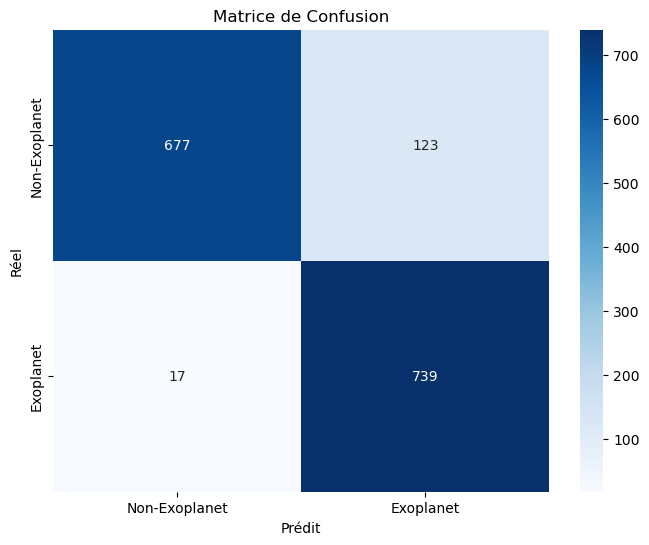

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       800
           1       0.86      0.98      0.91       756

    accuracy                           0.91      1556
   macro avg       0.92      0.91      0.91      1556
weighted avg       0.92      0.91      0.91      1556



In [19]:

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred_binary)

print(f'Accuracy: {accuracy}')

# Affichage de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_binary)
# Afficher la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Exoplanet', 'Exoplanet'],
            yticklabels=['Non-Exoplanet', 'Exoplanet'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

# Affichage du rapport de classification
class_report = classification_report(y_test, y_pred_binary)
print('Classification Report:')
print(class_report)

Meilleur modèle

49/49 [==============================] - 1s 7ms/step
Accuracy: 0.9241645244215938


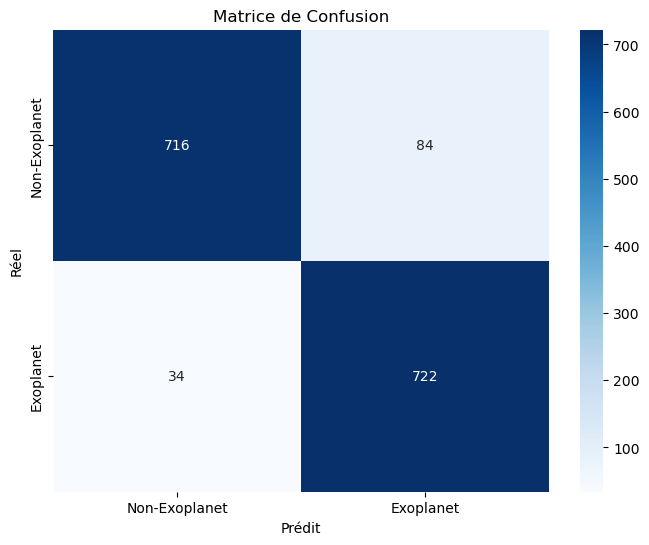

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       800
           1       0.90      0.96      0.92       756

    accuracy                           0.92      1556
   macro avg       0.93      0.93      0.92      1556
weighted avg       0.93      0.92      0.92      1556



In [20]:
# Charger le meilleur modèle
best_model = load_model('./models/best-'+modele_nom+".h5")

# données du meilleur modèle 
#X_test_reshaped = X_test.reshape(-1, 1, 1)

#accuracy
y_pred = best_model.predict(X_test_reshaped)
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy}')

# Affichage de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_binary)
# Afficher la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Exoplanet', 'Exoplanet'],
            yticklabels=['Non-Exoplanet', 'Exoplanet'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

# Affichage du rapport de classification
class_report = classification_report(y_test, y_pred_binary)
print('Classification Report:')
print(class_report)

## CONCLUSION

PCA n'apporte rien en terme d'amélioration du modèle sur ce jeu de données.